In [1]:
%matplotlib inline

In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from numpy import pi, sqrt

# set the random seed
np.random.seed(42)

2023-03-15 02:20:56.942207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
prog = sf.Program(3)

In [4]:
alpha = 1+0.5j
r = np.abs(alpha)
phi = np.angle(alpha)

with prog.context as q:
    # prepare initial states
    Coherent(r, phi) | q[0]
    Squeezed(-2) | q[1]
    Squeezed(2) | q[2]

    # apply gates
    BS = BSgate(pi/4, pi)
    BS | (q[1], q[2])
    BS | (q[0], q[1])

    # Perform homodyne measurements
    MeasureX | q[0]
    MeasureP | q[1]

    # Displacement gates conditioned on
    # the measurements
    Xgate(sqrt(2) * q[0].par) | q[2]
    Zgate(-sqrt(2) * q[1].par) | q[2]

In [5]:
eng = sf.Engine('fock', backend_options={"cutoff_dim": 15})

In [6]:
result = eng.run(prog, shots=1, modes=None, compile_options={})

In [7]:
print(result.samples)

[[0.19890199 0.17330173]]


In [8]:
print(result.state)
state = result.state


<FockState: num_modes=3, cutoff=15, pure=False, hbar=2>


In [9]:
print(state.dm().shape)

(15, 15, 15, 15, 15, 15)


In [10]:
rho2 = np.einsum('kkllij->ij', state.dm())
print(rho2.shape)

(15, 15)


In [11]:
probs = np.real_if_close(np.diagonal(rho2))
print(probs)

[3.10694907e-01 3.62467630e-01 2.11807608e-01 8.23802050e-02
 2.43874177e-02 5.83556629e-03 1.26776314e-03 2.37656289e-04
 8.43934922e-05 1.78787082e-06 1.52342119e-04 1.07036413e-05
 3.36055927e-04 1.47426072e-05 1.92773805e-04]


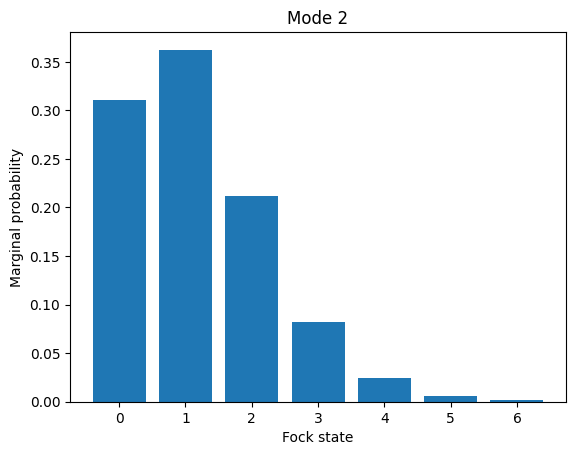

In [12]:
from matplotlib import pyplot as plt
plt.bar(range(7), probs[:7])
plt.xlabel('Fock state')
plt.ylabel('Marginal probability')
plt.title('Mode 2')
plt.show()

In [13]:
fock_probs = state.all_fock_probs()
fock_probs.shape
print(np.sum(fock_probs, axis=(0,1)))

[3.10694907e-01 3.62467630e-01 2.11807608e-01 8.23802050e-02
 2.43874177e-02 5.83556629e-03 1.26776314e-03 2.37656289e-04
 8.43934922e-05 1.78787082e-06 1.52342119e-04 1.07036413e-05
 3.36055927e-04 1.47426072e-05 1.92773805e-04]


In [14]:
from strawberryfields.ops import Sgate, BSgate, Rgate, MeasureHomodyne


In [15]:
np.random.seed(42)
n = 20

r = 1.0
length = n - 1
alpha = [np.pi / 4] * length
phi = [0] * length
theta = [0] * length

prog0 = sf.Program(n)
with prog0.context as q:
    for i in range(n - 1):
        Sgate(r) | q[i + 1]
        BSgate(alpha[i]) | (q[i], q[i + 1])
        Rgate(phi[i]) | q[i + 1]
        MeasureHomodyne(theta[i]) | q[i]
eng0 = sf.Engine("gaussian")
result0 = eng0.run(prog0)

In [16]:
print(result0.samples)

[[-0.10417347  0.60228311 -0.00316101  0.34561221  0.25296546 -0.13280689
  -0.67985316 -0.19192785  0.12600941 -0.51235116 -0.07813559 -0.52072239
   0.04318271  0.13989725 -0.10611505  0.68226231 -0.38850925 -0.44870008
  -0.72062428]]


In [17]:
from strawberryfields.tdm.program import shift_by

l = [0, 1, 2, 3, 4]
shift_by(l, 1)


[1, 2, 3, 4, 0]

In [18]:
np.random.seed(42)  
prog1 = sf.Program(2)
n = 20
with prog1.context as q:
    for i in range(n - 1):
        Sgate(r) | q[1]
        BSgate(alpha[i]) | (q[0], q[1])
        Rgate(phi[i]) | q[1]
        MeasureHomodyne(theta[i]) | q[0]
        
        q = shift_by(q, 1)
eng1 = sf.Engine("gaussian")
result1 = eng1.run(prog1)
print(result1.samples)

[[-0.72062428 -0.44870008]]


In [19]:
print(result1.samples_dict)

{0: [array([-0.10417347]), array([-0.00316101]), array([0.25296546]), array([-0.67985316]), array([0.12600941]), array([-0.07813559]), array([0.04318271]), array([-0.10611505]), array([-0.38850925]), array([-0.72062428])], 1: [array([0.60228311]), array([0.34561221]), array([-0.13280689]), array([-0.19192785]), array([-0.51235116]), array([-0.52072239]), array([0.13989725]), array([0.68226231]), array([-0.44870008])]}


In [20]:
np.random.seed(42) 
N = 2  
prog2 = sf.TDMProgram(N=N)

with prog2.context(alpha, phi, theta) as (p, q):
    Sgate(r, 0) | q[1]
    BSgate(p[0]) | (q[0], q[1])
    Rgate(p[1]) | q[1]
    MeasureHomodyne(p[2]) | q[0]
eng2 = sf.Engine("gaussian")
result2 = eng2.run(prog2)
print(result2.samples)

[[[-0.10417347  0.60228311 -0.00316101  0.34561221  0.25296546
   -0.13280689 -0.67985316 -0.19192785  0.12600941 -0.51235116
   -0.07813559 -0.52072239  0.04318271  0.13989725 -0.10611505
    0.68226231 -0.38850925 -0.44870008 -0.72062428]]]


In [21]:
def singleloop(r, alpha, phi, theta, shots):
    """Single loop program.

    Args:
        r (float): squeezing parameter
        alpha (Sequence[float]): beamsplitter angles
        phi (Sequence[float]): rotation angles
        theta (Sequence[float]): homodyne measurement angles
        shots (int): number of times the circuit is sampled
    Returns:
        list: homodyne samples from the single loop simulation
    """

    prog = sf.TDMProgram(N=2)
    with prog.context(alpha, phi, theta) as (p, q):
        Sgate(r, 0) | q[1]
        BSgate(p[0]) | (q[0], q[1])
        Rgate(p[1]) | q[1]
        MeasureHomodyne(p[2]) | q[0]
    eng = sf.Engine("gaussian")
    result = eng.run(prog, shots=shots)
    # We only want the samples from concurrent mode 0
    return result.samples_dict[0]

In [22]:
np.random.seed(42)  
singleloop(r, alpha, phi, theta, 1)  

array([[-0.10417347,  0.60228311, -0.00316101,  0.34561221,  0.25296546,
        -0.13280689, -0.67985316, -0.19192785,  0.12600941, -0.51235116,
        -0.07813559, -0.52072239,  0.04318271,  0.13989725, -0.10611505,
         0.68226231, -0.38850925, -0.44870008, -0.72062428]])

In [23]:
r = 2.0
alpha = [np.pi / 4, 0]
phi = [0, np.pi / 2]
theta = [0, 0]  # We will measure the positions by setting theta = [0,0]
shots = 2500

samplesEPRxx = singleloop(r, alpha, phi, theta, shots)

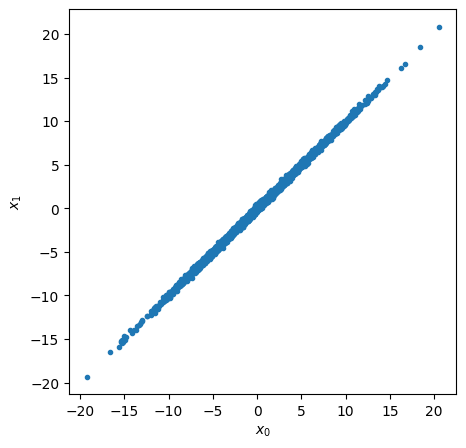

In [24]:
samplesxx = samplesEPRxx.T
x0 = samplesxx[0]
x1 = samplesxx[1]

# We now want to look at the samples
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(x0, x1, ".")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_{1}$")
plt.show()

In [25]:
sample_var_xx = np.var(x0 - x1)
sample_var_xx

0.03650153317129029

In [26]:
expected_var_xx = 2 * np.exp(-2 * r)
expected_var_xx

0.03663127777746836

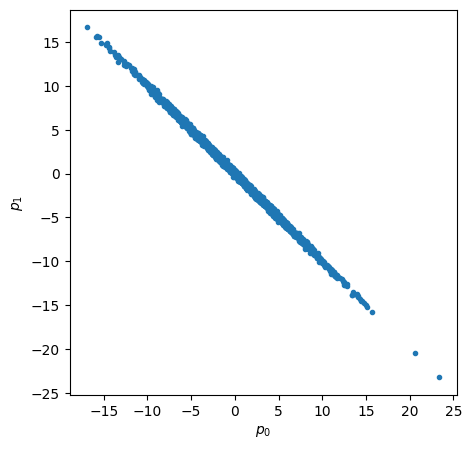

In [27]:
theta = [np.pi / 2, np.pi / 2]  # Now we homodyne the p-quadratures by setting thr angle to pi/2
samplesEPRpp = singleloop(r, alpha, phi, theta, shots)

samplespp = samplesEPRpp.T
p0 = samplespp[0]
p1 = samplespp[1]

plt.figure(figsize=(5, 5))
plt.plot(p0, p1, ".")
plt.xlabel(r"$p_0$")
plt.ylabel(r"$p_{1}$")
plt.show()

In [28]:
np.var(p0 + p1), 2 * np.exp(-2 * r)

(0.035484004498602846, 0.03663127777746836)

In [29]:
n = 10
vac_modes = 1  # This is an ancilla mode that is used at the beginning of the protocol
shots = 1
r = 4
alpha = [np.arccos(np.sqrt(1 / (n - i + 1))) if i != n + 1 else 0 for i in range(n + vac_modes)]
alpha[0] = 0.0
phi = [0] * (n + vac_modes)
phi[0] = np.pi / 2
theta = [0] * (n + vac_modes)  # We will measure first all the states in the X quadrature

singleloop(r, alpha, phi, theta, shots)

array([[-1.52220534, -1.23988693, -1.26801579, -1.23267925, -1.26416284,
        -1.2843186 , -1.26506774, -1.28691118, -1.24585304, -1.23932062,
        -1.2995661 ]])

In [30]:
theta = [np.pi / 2] * (n + vac_modes)  # Now we measure in p quadrature

samplep = singleloop(r, alpha, phi, theta, shots)
samplep

array([[ -0.52960821,  29.02743432, -93.3646886 ,  32.95431112,
        -39.99464345,  45.80328279, -52.37852011,  59.10381464,
         -8.2737421 ,   7.31907984,  19.76999235]])

In [31]:
np.sum(samplep[1:]) 

0.0

In [32]:
shots = 10000
theta = [0] * (n + vac_modes)
samplesGHZx = singleloop(r, alpha, phi, theta, shots)

nullifier_X = lambda sample: (sample - sample[-1])[vac_modes:-1]
val_nullifier_X = np.var([nullifier_X(x) for x in samplesGHZx], axis=0)

In [33]:
val_nullifier_X

array([0.00069353, 0.00066663, 0.00066681, 0.00067528, 0.0006789 ,
       0.00068246, 0.00067754, 0.0006766 , 0.00067778])

In [34]:
2 * np.exp(-2 * r)

0.0006709252558050236

In [35]:
from braket.strawberryfields_plugin import BraketEngine

eng = BraketEngine("arn:aws:braket:us-east-1::device/qpu/xanadu/Borealis")
device = eng.device

In [36]:
from strawberryfields.tdm import borealis_gbs, get_mode_indices

gate_args_list = borealis_gbs(device, modes=216, squeezing="high")
delays = [1, 6, 36]
n, N = get_mode_indices(delays)

2023-03-15 02:49:40,245 - WARNING - 117/259 arguments of phase gate 1 have been shifted by pi in order to be compatible with the phase modulators.
2023-03-15 02:49:40,247 - WARNING - 139/259 arguments of phase gate 2 have been shifted by pi in order to be compatible with the phase modulators.


In [37]:
from strawberryfields.ops import Sgate, Rgate, BSgate, MeasureFock

prog = sf.TDMProgram(N)

with prog.context(*gate_args_list) as (p, q):
    Sgate(p[0]) | q[n[0]]
    for i in range(len(delays)):
        Rgate(p[2 * i + 1]) | q[n[i]]
        BSgate(p[2 * i + 2], np.pi / 2) | (q[n[i + 1]], q[n[i]])
    MeasureFock() | q[0]

In [ ]:
shots = 1000
results = eng.run(prog, shots=shots, crop=True)
print(results.samples)